In [1]:
from detect_intermediates import *
from interpret_tICs import *

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
#from grids import *
from docking_analysis import *

/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
import io_functions
from imp import reload
reload(io_functions)
from io_functions import *

In [4]:
from operator import itemgetter

In [5]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
from get_variable_names import *
inactive_dir='/home/enf/md_simulations/b2ar/reference_receptors/2RH1_prepped-A.pdb'
active_dir='/home/enf/md_simulations/b2ar/reference_receptors/3P0G_pymol_prepped-A.pdb'
simulation_structure='/home/enf/md_simulations/b2ar/reference_receptors/ionized.pdb'
common_residues_pkl='/home/enf/md_simulations/b2ar/reference_receptors/common_residues2.pkl'
contact_residues = find_common_residues([inactive_dir, active_dir, simulation_structure], common_residues_pkl)


[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282

In [7]:
import os
import sys
import csv


# all the parameters

exacycle = False

n_clusters = 300
lag_time = 5
if exacycle:
  lag_time *= 2

msm_lag_time = 5
n_components = 10
n_samples = 10
n_macrostates = 25
n_trees = 100

precision = "SP"

sparse = True
wolf = True

is_sparse = ""
if(sparse): is_sparse = "sparse-"

shrinkage_string = ""
rho_string = ""
if wolf and not sparse:
  wolf_string = "_wolf_"
  shrinkage = None
  shrinkage_string = "autoShrinkage"
  rho = None
  rho_string = ""
elif wolf and sparse:
  wolf_string = "_wolf_"
  shrinkage = None
  shrinkage_string = "autoShrinkage"
  rho = 0.005
  rho_string = "_rho0pt005"
else:
  wolf_string = ""
  shrinkage = 0.001
  shrinkage_string = "0pt001"
  rho = None
  rho_string = ""

traj_ext = ".h5"
base = "/home/enf/md_simulations/b2ar/Salmeterol"
traj_dir = "/home/enf/md_simulations/b2ar/Salmeterol/h5_trajectories"
structure = None
iterative = False
featurize_parallel = True
sampling_method = "random"
precision = "SP"

In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [8]:
feature_name="contact_6pt6_angstroms"
ori_feature_name = copy.deepcopy(feature_name)

In [9]:
lag_time = 5
n_components = 10
n_clusters = 100

rho = 0.01 # tica regularization parameter
rho_string = "0pt01"
lag_time=50

In [10]:
schemes = ["closest-heavy", "CA"]
feature_name = "%s-CA-py3-far" %ori_feature_name
#feature_name = "%s_phi_psi_chi2" %feature_name
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
#tica_dir = "%s-with-inactive" %tica_dir
tica_dir = "%s-backup" %tica_dir
ori_tica_dir = copy.deepcopy(tica_dir)
#tica_dir = "%s-normalized" % ori_tica_dir
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/b2ar/Salmeterol/featurescontact_6pt6_angstroms-CA-py3-far
/home/enf/md_simulations/b2ar/Salmeterol/featurescontact_6pt6_angstroms-CA-py3-far


In [11]:
"""
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))
"""

"\nfrom ipyparallel import Client\nrc = Client()\nprint(len(rc.ids))\ndview = rc[:]\ndview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))\n"

In [12]:
"""
user_defined_features_dir = "%s/user_defined_features" %traj_dir
if not os.path.exists(user_defined_features_dir):
    os.makedirs(user_defined_features_dir)
compute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, None,
                                        feature_name_residues_dict, user_defined_features_file, worker_pool=None, 
                                        save_dir=user_defined_features_dir, parallel=True, overwrite=False)
"""

'\nuser_defined_features_dir = "%s/user_defined_features" %traj_dir\nif not os.path.exists(user_defined_features_dir):\n    os.makedirs(user_defined_features_dir)\ncompute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, None,\n                                        feature_name_residues_dict, user_defined_features_file, worker_pool=None, \n                                        save_dir=user_defined_features_dir, parallel=True, overwrite=False)\n'

In [ ]:
"""
ref_user_defined_features_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"
ref_user_defined_features_dir = "%s/ref_user_defined_features" %traj_dir
if not os.path.exists(ref_user_defined_features_dir):
    os.makedirs(ref_user_defined_features_dir)

compute_user_defined_features_wrapper(ref_receptors_dir, ".pdb", inactive_dir, active_dir, None,
                                        feature_name_residues_dict, ref_user_defined_features_file, worker_pool=None, 
                                        save_dir=ref_user_defined_features_dir, parallel=False, overwrite=True)
"""

'\nref_user_defined_features_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"\nref_user_defined_features_dir = "%s/ref_user_defined_features" %traj_dir\nif not os.path.exists(ref_user_defined_features_dir):\n    os.makedirs(ref_user_defined_features_dir)\n\ncompute_user_defined_features_wrapper(ref_receptors_dir, ".pdb", inactive_dir, active_dir, None,\n                                        feature_name_residues_dict, ref_user_defined_features_file, worker_pool=None, \n                                        save_dir=ref_user_defined_features_dir, parallel=False, overwrite=True)\n'

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
cutoff = 0.66

# output
# ---> permutations of tuple pairs (res1, res2)
# |   distance(res1, res2) at time t
# |
# time t
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir, simulation_structure], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel=True, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes, binarize=None, redo=False, within_turn=False) # removed worker_pool = dview, added parallel = True

already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already feat

In [ ]:
# returns ordered list of every dataset file (features)
get_trajectory_files(features_dir, ".dataset")

In [ ]:
# featurized_trajs = load_file_list(get_trajectory_files(features_dir, ".dataset"))

In [ ]:
# [(featurized_trajs[i].shape, get_trajectory_files(traj_dir, traj_ext)[i]) for i in range(0, len(featurized_trajs))]

In [ ]:
"""
n = StandardScaler()
for feature in featurized_trajs:
    n.partial_fit(feature)
# normalizing features
# transforms features to zero mean and unit variance (z-scoring)
save_file = "%s/normalizer.h5" %features_dir
verbosedump(n, save_file)
"""

In [ ]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [ ]:
dir(feature_residues[0])
dir(feature_residues[0].residue_i)
feature_residues[0].residue_i.resSeq

In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
# fit the tica model, apply model to each matrix
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=None, lag_time = lag_time, 
                  n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage,
                  parallel=False, traj_ext = traj_ext, normalize=True,
                  partial_fit=False, recompute_tica = False) # deleted features=featurized_trajs

In [ ]:
#bw_trajectories = [t for t in get_trajectory_files(traj_dir, ".h5") if "RUN" in t] # fixing "chain" problem

In [ ]:
# chain swapping

"""
from functools import partial
from importlib import reload
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import swap_chains_in_traj

swap_chains_in_traj_partial = partial(swap_chains_in_traj, chains=("I", "A"))
dview.map_sync(swap_chains_in_traj_partial, bw_trajectories)
"""

In [ ]:
# [(c.id, len([r for r in c.residues if r.is_protein])) for c in t.topology.chains]

In [ ]:
# featurize reference receptors (controls)

import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

ref_receptors_dir = '/home/enf/md_simulations/b2ar/reference_receptors'
featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir, simulation_structure], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel=False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes, binarize=None, redo=False, within_turn=False)

#featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
#                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
#                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes, within_turn=False, binarize=None, redo=False)

In [ ]:
ref_features = load_file_list(get_trajectory_files(ref_features_dir, '.dataset'))
ref_features
for x in ref_features :
    print(x.shape)

In [ ]:
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=compat_verboseload("%s/normalizer.h5" %features_dir))


In [25]:
feature_residues

[ALA119 to ALA78,
 ALA119 to ASP79,
 ALA119 to LEU124,
 ALA119 to LEU75,
 ALA119 to MET82,
 ALA119 to SER161,
 ALA119 to SER207,
 ALA119 to SER74,
 ALA119 to TRP158,
 ALA119 to VAL114,
 ALA119 to VAL157,
 ALA128 to GLU122,
 ALA128 to ILE135,
 ALA128 to ILE214,
 ALA128 to ILE278,
 ALA128 to MET215,
 ALA128 to MET279,
 ALA128 to PHE133,
 ALA128 to PRO211,
 ALA128 to THR123,
 ALA128 to TYR219,
 ALA128 to TYR326,
 ALA128 to VAL216,
 ALA128 to VAL218,
 ALA128 to VAL222,
 ALA134 to GLN142,
 ALA134 to LEU144,
 ALA134 to LEU145,
 ALA134 to LYS140,
 ALA134 to LYS267,
 ALA134 to PHE139,
 ALA134 to SER143,
 ALA134 to THR68,
 ALA134 to TYR141,
 ALA134 to VAL129,
 ALA150 to LEU145,
 ALA150 to LEU155,
 ALA150 to PHE71,
 ALA150 to SER143,
 ALA150 to TYR70,
 ALA150 to VAL126,
 ALA150 to VAL67,
 ALA176 to ALA181,
 ALA176 to ASN196,
 ALA176 to GLN197,
 ALA176 to ILE182,
 ALA176 to PHE194,
 ALA176 to THR195,
 ALA176 to TYR185,
 ALA181 to ALA186,
 ALA181 to ARG175,
 ALA181 to ASP192,
 ALA181 to CYS190,
 A

In [26]:
import custom_tica
reload(custom_tica)
from custom_tica import *
#transform_to_h5(projection_operator_dir, features_dir, projected_features_dir, worker_pool=None, parallel=True, normalizer=compat_verboseload("%s/normalizer.h5" %features_dir))

In [27]:
tica_object = compat_verboseload(projection_operator_dir)

In [28]:
with open(projection_operator_dir, 'rb') as f:
    tica_object = pickle.load(f, encoding='latin1') 

In [29]:
#all_tica = compat_verboseload(projected_features_dir)
#all_tica = [x[:,range(1,10)] for x in all_tica]
#print(all_tica[0].shape)
#print(len(all_tica))
#verbosedump(all_tica, projected_features_dir)


In [30]:
#n_components=9

In [31]:
tica_object.timescales_

array([ 737.05920774,  720.14166836,  669.30667022,  579.91041367,
        445.26316753,  398.429576  ,  397.17247717,  390.47198856,
        372.69426165,  296.83517177])

In [32]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

loading "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/phi_psi_chi2_allprot_projected.h5"...
()
None
Done plotting columns


In [33]:
feature_indices = []
traj_basenames = get_trajectory_files(traj_dir, ".h5")
traj_basenames = [os.path.splitext(os.path.basename(t))[0] for t in traj_basenames]
feature_basenames = get_trajectory_files(features_dir, ".dataset")
feature_basenames = [os.path.splitext(os.path.basename(t))[0] for t in feature_basenames]
for i, traj_basename in enumerate(traj_basenames):
    if traj_basename in feature_basenames:
        feature_indices.append(int(i))

In [34]:
tica_coords = compat_verboseload(projected_features_dir)
#pnas_coords = compat_verboseload(user_defined_features_file)
#pnas_coords = [pnas_coords[i] for i in feature_indices]
tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
#pnas_names = sorted(feature_name_residues_dict.keys())

In [36]:
# prints total number of frames that we have (t=0 - t=n)
print(np.concatenate(tica_coords).shape)
#print(np.concatenate(pnas_coords).shape)

(139932, 10)


In [37]:
from plots import *

In [38]:
#plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [39]:
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)

In [40]:
feature_names = compat_verboseload(feature_residues_pkl)

In [46]:
ref_features = [load_file(f) for f in get_trajectory_files(ref_features_dir, ".dataset")]
print(len(ref_features))
print(ref_features[0].shape)
print(ref_features[1].shape)
print(len(feature_names))
ref_features = pd.DataFrame(np.vstack(ref_features), columns=[str(f) for f in feature_names])

loading /home/enf/md_simulations/b2ar/Salmeterol/featurescontact_6pt6_angstroms-CA-py3-far/reference_receptors/2RH1_prepped-A.dataset
loading /home/enf/md_simulations/b2ar/Salmeterol/featurescontact_6pt6_angstroms-CA-py3-far/reference_receptors/3P0G_pymol_prepped-A.dataset
loading /home/enf/md_simulations/b2ar/Salmeterol/featurescontact_6pt6_angstroms-CA-py3-far/reference_receptors/ionized.dataset
3
(1, 2610)
(1, 2610)
2610


In [47]:
ref_features

,ALA119 to ALA78,ALA119 to ASP79,ALA119 to LEU124,ALA119 to LEU75,ALA119 to MET82,ALA119 to SER161,ALA119 to SER207,ALA119 to SER74,ALA119 to TRP158,ALA119 to VAL114,...,VAL292_CA to VAL297_CA,VAL292_CA to VAL307_CA,VAL317_CA to VAL87_CA,VAL34_CA to VAL39_CA,VAL39_CA to VAL44_CA,VAL44_CA to VAL86_CA,VAL44_CA to VAL87_CA,VAL48_CA to VAL81_CA,VAL81_CA to VAL86_CA,VAL81_CA to VAL87_CA
0,0.461015,0.776682,0.486704,0.526418,0.894512,0.325657,0.624341,0.559677,0.379954,0.494914,...,0.856652,0.969607,0.871400,0.855769,0.883398,0.954805,0.663171,0.835061,0.688208,0.882706
1,0.376533,0.656476,0.488533,0.495369,0.652861,0.324367,0.638784,0.520898,0.355660,0.475796,...,0.847109,0.907385,0.924539,0.859190,0.883134,0.934655,0.626340,0.816161,0.699942,0.874036
2,0.394422,0.679888,0.481039,0.518173,0.811594,0.314504,0.644040,0.546482,0.383042,0.479343,...,0.860910,0.847107,0.928936,0.880690,0.872936,0.951248,0.652403,0.829677,0.711434,0.901588


In [50]:
#import interpret_tICs
#reload(interpret_tICs)
#from interpret_tICs import *

tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)


Interpreting tIC 1
feature_importances_df.shape
(12, 5)
residue_importances_df.shape
(18, 2)
              feature_name      res_i      res_j  importance  \
10  Gly102_Ca To Thr189_Ca  Gly102_Ca  Thr189_Ca    0.570747   
4         Gly102 To Thr189     Gly102     Thr189   -0.396816   
1         Asn103 To Cys191     Asn103     Cys191   -0.342891   
5   Asn103_Ca To Glu188_Ca  Asn103_Ca  Glu188_Ca    0.338240   
11   Lys97_Ca To Thr189_Ca   Lys97_Ca  Thr189_Ca    0.261177   
9   Glu188_Ca To Phe104_Ca  Glu188_Ca  Phe104_Ca   -0.242669   
3         Glu188 To Thr100     Glu188     Thr100    0.242470   
8   Glu187_Ca To Gly102_Ca  Glu187_Ca  Gly102_Ca   -0.161114   
0          Ala76 To Cys327      Ala76     Cys327    0.149930   
7   Cys190_Ca To Phe101_Ca  Cys190_Ca  Phe101_Ca    0.121625   
6   Cys106_Ca To Cys190_Ca  Cys106_Ca  Cys190_Ca   -0.082715   
2         Asn103 To Glu188     Asn103     Glu188    0.061434   

                   feature  
10  GLY102_CA to THR189_CA  
4         GLY102

In [51]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_subsampled_features_file = "%s/features_subsampled.pkl" % tica_dir
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features[0], feature_names)
if not os.path.exists(tic_subsampled_features_file):
    subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file)

In [52]:
tic_subsampled_features_file

'/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl'

In [53]:
protein_top_features = load_file(tic_subsampled_features_file)
protein_top_features_concat = pd.concat(protein_top_features)

loading /home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/features_subsampled.pkl


In [57]:
salm_trajs = []
apo_trajs = []
salm_nb_trajs = []
trajs = get_trajectory_files(traj_dir, ".h5")
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "salm_nb" not in t]
for i, traj in enumerate(trajs):
    if "NNNS" in traj or "APO" in traj:
        apo_trajs.append(i)
    elif "NNWS" in traj or "nonbWL" in traj:
        salm_trajs.append(i)
    elif "WNWS" in traj or "RWNW" in traj:
        salm_nb_trajs.append(i)

#user_defined_coords = load_file(user_defined_features_file)

In [58]:
#salm_pnas = [user_defined_coords[i] for i in salm_trajs]
#apo_pnas = [user_defined_coords[i] for i in apo_trajs]
#salm_nb_pnas = [user_defined_coords[i] for i in salm_nb_trajs]
#salm_nb_pnas = [user_defined_coords[i] for i in salm_nb_trajs]
#f338a_pnas = [user_defined_coords[i] for i in f338a_trajs]

In [59]:
#salm_pnas_file = "%s/salm.h5" % whole_trajectory_pnas
#apo_pnas_file = "%s/apo.h5" % whole_trajectory_pnas
#salm_nb_pnas_file = "%s/salm_nb.h5" % whole_trajectory_pnas
#salm_nb_pnas_file = "%s/salm_nb.h5" % whole_trajectory_pnas
#f338a_pnas_file = "%s/f338a.h5" % whole_trajectory_pnas

In [60]:
"""
from imp import reload
import analysis
reload(analysis)
from analysis import *
import seaborn as sns
salm_pnas_concatenated = np.concatenate(salm_pnas)
print(np.shape(salm_pnas_concatenated))
apo_pnas_concatenated = np.concatenate(apo_pnas)
#salm_nb_pnas_concatenated = np.concatenate(salm_nb_pnas)
salm_nb_pnas_concatenated = np.concatenate(salm_nb_pnas)
f338a_pnas_concatenated = np.concatenate(f338a_pnas)

verbosedump(salm_pnas, salm_pnas_file)
verbosedump(apo_pnas, apo_pnas_file)
#verbosedump(salm_nb_pnas, salm_nb_pnas_file)
verbosedump(salm_nb_pnas, salm_nb_pnas_file)
verbosedump(f338a_pnas, f338a_pnas_file)


columns=sorted(feature_name_residues_dict.keys())
#plot_columns(whole_trajectory_pnas, salm_pnas_file, titles=columns, main = "salm", tICA = False, scale = 1.0, refcoords_file = None)
#plot_columns(whole_trajectory_pnas, apo_pnas_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)

#df = pd.DataFrame(salm_pnas_concatenated, columns=sorted(feature_name_residues_dict.keys()))
#sns.jointplot(x="tm6_tm3_dist", y="rmsd_npxxy_inactive", data=df, kind="kde")
#plt.hexbin(salm_pnas_concatenated[:,0], salm_pnas_concatenated[:,2], cmap=plt.cm.YlOrRd_r)
"""

'\nfrom imp import reload\nimport analysis\nreload(analysis)\nfrom analysis import *\nimport seaborn as sns\nsalm_pnas_concatenated = np.concatenate(salm_pnas)\nprint(np.shape(salm_pnas_concatenated))\napo_pnas_concatenated = np.concatenate(apo_pnas)\n#salm_nb_pnas_concatenated = np.concatenate(salm_nb_pnas)\nsuf_pnas_concatenated = np.concatenate(suf_pnas)\nf338a_pnas_concatenated = np.concatenate(f338a_pnas)\n\nverbosedump(salm_pnas, salm_pnas_file)\nverbosedump(apo_pnas, apo_pnas_file)\n#verbosedump(salm_nb_pnas, salm_nb_pnas_file)\nverbosedump(suf_pnas, suf_pnas_file)\nverbosedump(f338a_pnas, f338a_pnas_file)\n\n\ncolumns=sorted(feature_name_residues_dict.keys())\n#plot_columns(whole_trajectory_pnas, salm_pnas_file, titles=columns, main = "salm", tICA = False, scale = 1.0, refcoords_file = None)\n#plot_columns(whole_trajectory_pnas, apo_pnas_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)\n\n#df = pd.DataFrame(salm_pnas_concatenated, columns=so

In [61]:
salm_nb_tica_file = "%s/salm_nb_tica.h5" % tica_dir
salm_tica_file = "%s/salm_tica.h5" % tica_dir
apo_tica_file = "%s/apo_tica.h5" % tica_dir
#salm_nb_tica_file = "%s/salm_nb_tica.h5" % tica_dir

In [66]:
tica_coords = compat_verboseload(projected_features_dir)
salm_nb_tica = [tica_coords[i] for i in salm_nb_trajs]
salm_tica = [tica_coords[i] for i in salm_trajs]
apo_tica = [tica_coords[i] for i in apo_trajs]


verbosedump(salm_nb_tica, salm_nb_tica_file)
verbosedump(salm_tica, salm_tica_file)
verbosedump(apo_tica, apo_tica_file)

columns = ["tIC%d" %i for i in range(1,n_components+1)]
#plot_columns(tica_dir, salm_tica_file, titles=columns, main = "salm", tICA = False, scale = 1.0, refcoords_file = None)
#plot_columns(tica_dir, apo_tica_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)


Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/salm_nb_tica.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/salm_tica.h5"... (<class 'list'>)
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_tica.h5"... (<class 'list'>)


In [67]:
print(np.concatenate(salm_nb_tica).shape)
print(np.concatenate(apo_tica).shape)
print(np.concatenate(salm_tica).shape)

(47939, 10)
(50340, 10)
(41653, 10)


In [68]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
n_clusters = 100
clusterer_dir = "%s/clusterer_%dclusters.h5" %(tica_dir, n_clusters)
if not os.path.exists(clusterer_dir):
    cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_dir)

In [69]:
print(clusterer_dir)

/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_100clusters.h5


In [70]:
salm_nb_clusterer_file = "%s/salm_nb_clusterer%d.h5" %(tica_dir, n_clusters)
salm_clusterer_file = "%s/salm_clusterer%d.h5" %(tica_dir, n_clusters)
apo_clusterer_file = "%s/apo_clusterer%d.h5" %(tica_dir, n_clusters)

In [71]:
clusterer = compat_verboseload(clusterer_dir)
cluster_labels = clusterer.labels_
salm_nb_clusters = [cluster_labels[i] for i in salm_nb_trajs]
salm_clusters = [cluster_labels[i] for i in salm_trajs]
apo_clusters = [cluster_labels[i] for i in apo_trajs]

salm_clusterer = copy.deepcopy(clusterer)
salm_clusterer.labels_ = salm_clusters
#if not os.path.exists(salm_clusterer_file):
verbosedump(salm_clusterer, salm_clusterer_file)

apo_clusterer = copy.deepcopy(clusterer)
apo_clusterer.labels_ = apo_clusters
    
#if not os.path.exists(apo_clusterer_file):
verbosedump(apo_clusterer, apo_clusterer_file)

salm_nb_clusterer = copy.deepcopy(clusterer)
salm_nb_clusterer.labels_ = salm_nb_clusters
    
#if not os.path.exists(salm_nb_clusterer_file):
verbosedump(salm_nb_clusterer, salm_nb_clusterer_file)

Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/salm_clusterer100.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer100.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/salm_nb_clusterer100.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


In [72]:
cluster_tica_averages = calculate_cluster_averages_per_feature(salm_clusterer, salm_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, n_components+1)])

In [73]:
import custom_msm
reload(custom_msm)
from custom_msm import *
from msm_resampled import *

In [74]:
apo_clusters_map = make_clusters_map(apo_clusterer)
salm_clusters_map = make_clusters_map(salm_clusterer)
salm_nb_clusters_map = make_clusters_map(salm_nb_clusterer)

1010
1144
251
562
418
344
1111
1183
0
240
700
22
0
129
221
0
460
232
86
1043
1075
195
2118
851
240
853
25
879
577
4
9
25
326
814
113
985
107
25
212
107
1158
119
330
21
74
726
1110
635
1165
17
400
509
69
64
903
240
749
807
1228
196
354
246
8
333
110
578
414
1075
292
851
805
476
590
322
81
10
209
194
356
993
757
5
1238
1024
254
503
439
1035
629
587
1
1148
522
465
387
125
932
2068
276
432
61
1089
0
504
822
318
0
266
879
0
308
1348
895
64
6
556
39
1160
1
473
0
198
737
104
831
915
1739
22
294
105
661
724
0
1380
245
498
61
153
279
671
1534
16
3
711
10
83
30
229
1813
106
102
1388
0
0
437
0
75
244
237
335
67
195
300
56
51
221
296
2
162
553
810
4
1277
8
523
39
0
241
366
1047
293
15
1785
1774
292
69
0
909
531
57
7
299
681
0
206
307
1224
549
678
0
46
1192
0
6930
102
629
0
1433
3
0
33
776
57
2159
193
619
124
0
0
1614
0
87
69
0
0
253
0
6
72
18
0
11
0
51
1825
149
1066
248
1362
229
278
201
0
233
632
240
1
0
996
0
59
2353
0
304
756
86
1347
173
543
756
192
58
0
2028
9
19
0
0
1054
535
245
37
623
0
708
3

In [ ]:
#plt.clf()
#plot_timescales(apo_clusterer_file, n_clusters, tica_dir, main="Apo MSM Timescales", lag_times=list(range(1,51,10)))

In [ ]:
#plt.clf()
#import custom_msm
#reload(custom_msm)
#from custom_msm import *
#plot_timescales(salm_clusterer_file, n_clusters, tica_dir, main="salm MSM Timescales", lag_times=[1,5,10,15,20])

In [ ]:
#plt.clf()
#plot_timescales(salm_nb_clusterer_file, n_clusters, tica_dir, main="salm_nb MSM Timescales", lag_times=list(range(1,51,10)))

In [75]:
import custom_msm
import importlib
importlib.reload(custom_msm)
from custom_msm import *

apo_lag_time=25.
prior_counts = 1e-5
ergodic_cutoff = 'off'
apo_msm_dir = os.path.join(tica_dir, "apo_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(apo_lag_time, str(prior_counts), n_clusters))
#if 1==1:
if not os.path.exists(apo_msm_dir):
    apo_msm = build_msm(apo_clusterer_file, apo_lag_time, apo_msm_dir, prior_counts, ergodic_cutoff)
else:
    apo_msm = compat_verboseload(apo_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(apo_trajs)
apo_resampled_traj_to_frames_file = os.path.join(tica_dir, "apo_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(apo_resampled_traj_to_frames_file):
apo_resampled_traj_to_frames = resample_by_msm(total_samples, apo_msm, apo_clusters_map, num_trajs, apo_resampled_traj_to_frames_file)
#else:
apo_resampled_traj_to_frames = compat_verboseload(apo_resampled_traj_to_frames_file)

#apo_pnas = compat_verboseload(apo_pnas_file)
#apo_pnas_resampled_file = os.path.join(tica_dir, "apo_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
#resample_features_by_msm_equilibirum_pop(apo_pnas, apo_resampled_traj_to_frames, apo_pnas_resampled_file)
#apo_pnas_resampled = compat_verboseload(apo_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

apo_tica = compat_verboseload(apo_tica_file)
apo_tica_resampled_file = os.path.join(tica_dir, "apo_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(apo_tica, apo_resampled_traj_to_frames, apo_tica_resampled_file)
apo_tica_resampled = compat_verboseload(apo_tica_resampled_file)

apo_clusterer = compat_verboseload(apo_clusterer_file)
apo_msm = compat_verboseload(apo_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = apo_msm.populations_

for cluster_id in apo_msm.mapping_.keys():
    state_id = apo_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)

#plot_all_tics_and_clusters(tica_dir, apo_tica_resampled_file, apo_clusterer_file, lag_time, tic_range=range(0,n_components), main = "Apo_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, apo_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_Apo_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

loading "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_clusterer100.h5"...
fitting msm to trajectories with 100 clusters and lag_time 25
MarkovStateModel(ergodic_cutoff='off', lag_time=25.0, n_timescales=None,
         prior_counts=1e-05, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/apo_msm_lag-time25_prior-counts1e-05_clusters100.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 97 states
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_componen

In [78]:

salm_lag_time=25
prior_counts = 1e-5
ergodic_cutoff='off'
salm_msm_dir = os.path.join(tica_dir, "salm_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(salm_lag_time, str(prior_counts), n_clusters))
#if 1==1:
if not os.path.exists(salm_msm_dir):
    salm_msm = build_msm(salm_clusterer_file, salm_lag_time, salm_msm_dir, prior_counts, ergodic_cutoff)
else:
    salm_msm = compat_verboseload(salm_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(salm_trajs)
salm_resampled_traj_to_frames_file = os.path.join(tica_dir, "salm_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(salm_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(salm_resampled_traj_to_frames_file):
salm_resampled_traj_to_frames = resample_by_msm(total_samples, salm_msm, salm_clusters_map, num_trajs, salm_resampled_traj_to_frames_file)
#else:
salm_resampled_traj_to_frames = compat_verboseload(salm_resampled_traj_to_frames_file)

#salm_pnas = compat_verboseload(salm_pnas_file)
#salm_pnas_resampled_file = os.path.join(tica_dir, "salm_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(salm_lag_time, str(prior_counts), n_clusters, total_samples))
#resample_features_by_msm_equilibirum_pop(salm_pnas, salm_resampled_traj_to_frames, salm_pnas_resampled_file)
#salm_pnas_resampled = compat_verboseload(salm_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

salm_tica = compat_verboseload(salm_tica_file)
salm_tica_resampled_file = os.path.join(tica_dir, "salm_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(salm_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(salm_tica, salm_resampled_traj_to_frames, salm_tica_resampled_file)
salm_tica_resampled = compat_verboseload(salm_tica_resampled_file)

salm_clusterer = compat_verboseload(salm_clusterer_file)
salm_msm = compat_verboseload(salm_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = salm_msm.populations_

for cluster_id in salm_msm.mapping_.keys():
    state_id = salm_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
#plot_all_tics_and_clusters(tica_dir, salm_tica_resampled_file, salm_clusterer_file, lag_time, tic_range=range(0,n_components), main = "salm_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, salm_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_salm_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

loading "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/salm_clusterer100.h5"...
fitting msm to trajectories with 100 clusters and lag_time 25
MarkovStateModel(ergodic_cutoff='off', lag_time=25, n_timescales=None,
         prior_counts=1e-05, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/salm_msm_lag-time25_prior-counts1e-05_clusters100.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 88 states
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_componen

In [ ]:
"""
graph_file = "%s/salm_clusters_%d_msm_lag_time%d_graph.graphml" % (tica_dir, n_clusters, salm_lag_time)
salm_tica_averages = calculate_cluster_averages_per_feature(salm_clusterer, salm_tica)
salm_cluster_attributes = {}
for i, title in enumerate(["tIC.%d" %i for i in range(1,n_components+1)]):
    salm_cluster_attributes[title] = salm_tica_averages[:,i]

salm_msm_attributes = {'eq_pops' : salm_msm.populations_}
construct_graph(salm_msm_dir, salm_clusterer_file, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None, cluster_attributes=salm_cluster_attributes, msm_attributes=salm_msm_attributes)
"""

In [79]:
salm_nb_lag_time=25
prior_counts = 1e-5
ergodic_cutoff='off'
salm_nb_msm_dir = os.path.join(tica_dir, "salm_nb_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(salm_nb_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(salm_nb_msm_dir):
    salm_nb_msm = build_msm(salm_nb_clusterer_file, salm_nb_lag_time, salm_nb_msm_dir, prior_counts, ergodic_cutoff)
else:
    salm_nb_msm = compat_verboseload(salm_nb_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 20000
num_trajs = len(salm_nb_trajs)
salm_nb_resampled_traj_to_frames_file = os.path.join(tica_dir, "salm_nb_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(salm_nb_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(salm_nb_resampled_traj_to_frames_file):
salm_nb_resampled_traj_to_frames = resample_by_msm(total_samples, salm_nb_msm, salm_nb_clusters_map, num_trajs, salm_nb_resampled_traj_to_frames_file)
#else:
salm_nb_resampled_traj_to_frames = compat_verboseload(salm_nb_resampled_traj_to_frames_file)

#salm_nb_pnas = compat_verboseload(salm_nb_pnas_file)
#salm_nb_pnas_resampled_file = os.path.join(tica_dir, "salm_nb_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(salm_nb_lag_time, str(prior_counts), n_clusters, total_samples))
#resample_features_by_msm_equilibirum_pop(salm_nb_pnas, salm_nb_resampled_traj_to_frames, salm_nb_pnas_resampled_file)
#salm_nb_pnas_resampled = compat_verboseload(salm_nb_pnas_resampled_file)

tica_concatenated = np.concatenate(compat_verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

salm_nb_tica = compat_verboseload(salm_nb_tica_file)
salm_nb_tica_resampled_file = os.path.join(tica_dir, "salm_nb_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(salm_nb_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(salm_nb_tica, salm_nb_resampled_traj_to_frames, salm_nb_tica_resampled_file)
salm_nb_tica_resampled = compat_verboseload(salm_nb_tica_resampled_file)

salm_nb_clusterer = compat_verboseload(salm_nb_clusterer_file)
salm_nb_msm = compat_verboseload(salm_nb_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = salm_nb_msm.populations_

for cluster_id in salm_nb_msm.mapping_.keys():
    state_id = salm_nb_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
#plot_all_tics_and_clusters(tica_dir, salm_nb_tica_resampled_file, salm_nb_clusterer_file, lag_time, tic_range=range(0,n_components), main = "salm_nb_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, salm_nb_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_salm_nb_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

loading "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/salm_nb_clusterer100.h5"...
fitting msm to trajectories with 100 clusters and lag_time 25
MarkovStateModel(ergodic_cutoff='off', lag_time=25, n_timescales=None,
         prior_counts=1e-05, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_components10contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/salm_nb_msm_lag-time25_prior-counts1e-05_clusters100.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 77 states
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled frames based on trajectories
Saving "/home/enf/md_simulations/b2ar/Salmeterol/sparse-tICA_t50_n_co

In [84]:
tica_resampled = np.vstack([compat_verboseload(salm_tica_resampled_file)[::1,], compat_verboseload(apo_tica_resampled_file)[::1,], compat_verboseload(salm_nb_tica_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - .5*stds[i], maxs[i] + .5*stds[i]] for i in range(0,len(mins))]

In [85]:
#ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
#ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

In [86]:
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

ref_pp_features = pd.DataFrame(get_features(ref_features_dir), columns=feature_names)

ref_pp_tica = pd.read_csv(ref_tica_coords, header=None).values
#ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,ref_pp_tica.shape[1])]

#ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
#ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

#ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

#ref_features = pd.concat([ref_pp_features*10., ref_lp_features*10., ref_pp_tica, ref_lp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/b2ar/Salmeterol/featurescontact_6pt6_angstroms-CA-py3-far/reference_receptors/2RH1_prepped-A.dataset
loading /home/enf/md_simulations/b2ar/Salmeterol/featurescontact_6pt6_angstroms-CA-py3-far/reference_receptors/3P0G_pymol_prepped-A.dataset
loading /home/enf/md_simulations/b2ar/Salmeterol/featurescontact_6pt6_angstroms-CA-py3-far/reference_receptors/ionized.dataset
(3, 2610)


In [ ]:
#coords_bounds_dict = {"tIC.4": [(8.0, 10.), (12., 15.)]}
#all_traj_files = get_trajectory_files(traj_dir, traj_ext)
#trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in salm_trajs], ".h5", [t.values for t in all_traj_features], 
#                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
#                            "%s/trajs_to_watch.csv" %pp_tica_dir)

Making delta G plots.
hi
(2, 19999)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 10.0)
hi
(2, 19999)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 10.0)
hi
(2, 19999)
Computed 2D KDE


KeyboardInterrupt: 

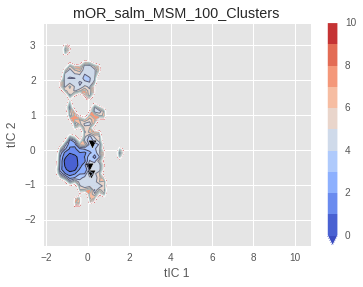

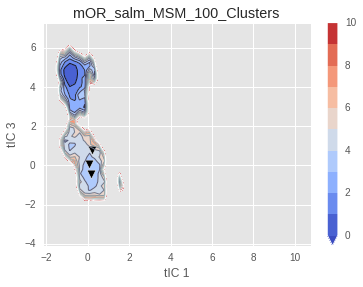

In [92]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(salm_tica_resampled[::1,:], 
           analysis_dir, titles = ["tIC %d" %i for i in range(1, n_components+1)], 
           main = "mOR_salm_MSM_%d_Clusters" %n_clusters, refcoords = ref_pp_tica, 
           axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=1, 
           min_density=None, max_diff=10., max_i = 1, custom_lims=custom_lims, n_levels=11, 
           n_pts=50j, parallel=False, remake=True)

Making delta G plots.
hi
(2, 20003)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 10.0)
hi
(2, 20003)
Computed 2D KDE


KeyboardInterrupt: 

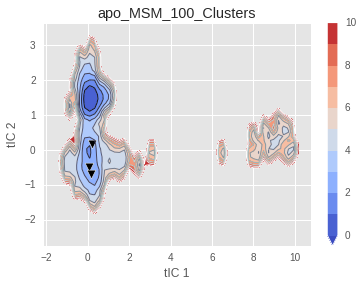

In [93]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(apo_tica_resampled[::1,:], 
           analysis_dir, titles = ["tIC %d" %i for i in range(1, n_components+1)], 
           main = "apo_MSM_%d_Clusters" %n_clusters, refcoords = ref_pp_tica, 
           axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=1, 
           min_density=None, max_diff=10., max_i = 1, custom_lims=custom_lims, n_levels=11, 
           n_pts=50j, parallel=False, remake=True)


Making delta G plots.
hi
(2, 20000)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 10.0)
hi
(2, 20000)
Computed 2D KDE


KeyboardInterrupt: 

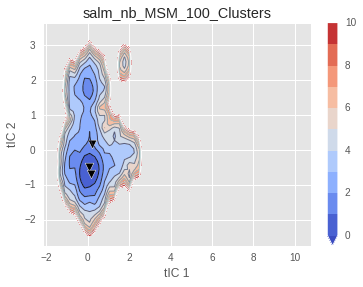

In [94]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(salm_nb_tica_resampled[::1,:], 
           analysis_dir, titles = ["tIC %d" %i for i in range(1, n_components+1)], 
           main = "salm_nb_MSM_%d_Clusters" %n_clusters, refcoords = ref_pp_tica, 
           axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=1, 
           min_density=None, max_diff=10., max_i = 1, custom_lims=custom_lims, n_levels=11, 
           n_pts=50j, parallel=False, remake=True)

In [ ]:
jointplots(salm_nb_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_salm_nb_MSM_%d_Clusters" %n_clusters, refcoords=ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=10, remake=True)

In [54]:
tica_resampled = np.vstack([compat_verboseload(salm_tica_resampled_file)[::1,], compat_verboseload(apo_tica_resampled_file)[::1,], compat_verboseload(salm_nb_tica_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]


In [ ]:
custom_lims

In [ ]:
print(custom_lims)
print(custom_lims[3][1])

In [55]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
refcoords_jointplots_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(refcoords_jointplots_dir):
    os.makedirs(refcoords_jointplots_dir)
jointplots(compat_verboseload(salm_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "salm MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=False, max_i=1)
jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=False, max_i=1)
jointplots(compat_verboseload(salm_nb_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "salm_nbentanil MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=custom_lims, n_pts=200j, n_levels=15, remake=False, parallel=False, max_i=1)



Making delta G plots.
1
2
3
4
5
6
(2, 19984)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732   0.73737192]
 [-0.27086734  0.45005798]]
7
(2, 19984)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -2.846076  ]
 [-0.27086734  0.34059189]]
8
(2, 19984)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -0.77531983]
 [-0.27086734  0.15601567]]
9
(2, 19984)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -0.86493743]
 [-0.27086734  0.67270475]]
Done plotting columns
Making delta G plots.
1
(2, 19998)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732   1.16827855]
 [-0.27086734 -0.90431764]]
2
(2, 19998)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -0.12336551]
 [-0.27086734 -0.51214134]]
3
(2, 19998)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)
[[ 0.1997732  -1.66948062]
 [-0.27086734  0.09047833]]
4
(

In [ ]:
ref_pp_tica

In [ ]:
np.concatenate(salm_tica).shape

In [ ]:
np.concatenate(apo_tica).shape

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(compat_verboseload(salm_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "salm MSM", refcoords=None, axes=None, data_j=salm_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None, remake=True)
#jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords=None, axes=None, data_j=apo_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None)
#jointplots(compat_verboseload(salm_nb_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "salm_nbentanil MSM", refcoords=None, axes=None, data_j=salm_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=8., custom_lims=None)

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *


In [ ]:
#sample_tIC_regions_silverman(np.concatenate(compat_verboseload(projected_features_dir))[::100,:], analysis_dir)
#get_kde_mins_and_maxes(np.concatenate(compat_verboseload(projected_features_dir))[::100,:], analysis_dir)
sample_kde_maxima(compat_verboseload(projected_features_dir), analysis_dir, trajs)

In [ ]:
jointplots(compat_verboseload(apo_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=5, min_density=None, max_diff=5., custom_lims=custom_lims)

In [ ]:
plot_columns(tica_dir, salm_pnas_resampled_file, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_salm_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

In [ ]:
#salm_tica = compat_verboseload(salm_tica_file)
#salm_tica_resampled_file = os.path.join(tica_dir, "salm_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled.h5" %(lag_time, str(prior_counts), n_clusters))
#resample_features_by_msm_equilibirum_pop(salm_tica, salm_resampled_traj_to_frames, salm_tica_resampled_file)
#salm_tica_resampled = compat_verboseload(salm_tica_resampled_file)
plot_columns(tica_dir, salm_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_salm_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=True)

In [ ]:
salm_clusterer = compat_verboseload(salm_clusterer_file)
salm_msm = compat_verboseload(salm_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = salm_msm.populations_

for cluster_id in salm_msm.mapping_.keys():
    state_id = salm_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)

#plot_all_tics_and_clusters(tica_dir, salm_tica_resampled_file, salm_clusterer_file, lag_time, tic_range=[0,3], main = "salm_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)


In [ ]:
len(dview)

In [126]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters= 1000
samples_dir = "%s/salm_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/salm_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(salm_clusterer_file, salm_tica_file, [traj_files[i] for i in salm_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=True, lig_name="LIG")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer_1000clusters_1samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/bu72_clusterer1000.h5"...
[[149 356]
 [379 392]
 [468 474]
 ..., 
 [218 185]
 [375 365]
 [294 237]]
1000
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_c

In [127]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters= 1000
samples_dir = "%s/salm_nb_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/salm_nb_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(salm_nb_clusterer_file, salm_nb_tica_file, [traj_files[i] for i in salm_nb_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=True, lig_name="LIG")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer_1000clusters_1samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/suf_clusterer1000.h5"...
[[494 114]
 [218 323]
 [ 38 170]
 ..., 
 [726 453]
 [714  48]
 [615 459]]
1000
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutof

In [67]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters= 100
samples_dir = "%s/all_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/all_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(clusterer_dir, projected_features_dir, traj_files, 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=None, parallel=False, lig_name="NON")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/all_clusterer_100clusters_1samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_100clusters.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_100clusters.h5"...
[[ 965    5]
 [ 760  289]
 [1444   39]
 [1667  224]
 [ 485   54]
 [ 339  428]
 [ 669  179]
 [ 783  303]
 [  99   47]
 [ 835   30]
 [1027  332]
 [ 354  101]
 [1708 

In [68]:
samples_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/all_clusterer_100clusters_1samples_samples_kdtree'

In [ ]:
get_trajectory_files(traj_dir, traj_ext)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 5
n_clusters=250
samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)

sample_from_clusterer(apo_clusterer_file, apo_tica_file, [traj_files[i] for i in apo_trajs],
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=None, parallel=True, lig_name="LIG")

In [ ]:
traj_files

In [ ]:
feature_name_residues_dict.keys()

In [ ]:

np.shape(apo_pnas_resampled)
msm_dir = os.path.join(tica_dir, "msm_lag-time%d_prior-counts%s_clusters%d_analysis" %(lag_time, str(prior_counts), n_clusters))
if not os.path.exists(msm_dir): os.makedirs(msm_dir)

#plot_columns(msm_dir, apo_pnas_resampled_file, titles = feature_name_residues_dict.keys(), main = "Apo-mOR", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False)

In [ ]:
import pip

def install(package):
    pip.main(['install', package])
    
install("moviepy")

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

for i, traj in enumerate(get_trajectory_files(traj_dir, traj_ext)):
    if "apo_rep_68." in traj:
        index=i
        break

jointplot(apo_pnas_resampled[::10,[6,3]], "%s/test.pdf" %msm_dir, trajectory=apo_pnas[index][::1,[6,3]], 
          titles=["TM6 to TM3 distance", "RMSD of NPxxY to Inactive"], main = "mOR Activation Pathway", 
          video_file = "%s/apo_68.mp4" %msm_dir, custom_xlim=[4.0, 16.0], custom_ylim= [0.0, 1.0])
#test("%s/test2.mp4" %msm_dir)

In [ ]:
build_msm(salm_clusterer_file, lag_time, msm_model_dir)
build_msm(apo_clusterer_file, lag_time, msm_model_dir)

In [ ]:
tics_1_5_file = os.path.join(tica_dir, "tICs_1_5.h5")
tics = load_file(projected_features_dir)
tics_1_5 = [x[:,range(1,5)] for x in tics]
verbosedump(tics_1_5, tics_1_5_file)

clusterer300_clusters = os.path.join(tica_dir, "clusterer300_clusters_tICs1_5.h5")
cluster_minikmeans(tica_dir, tics_1_5_file, traj_dir, n_clusters=300, clusterer_dir=clusterer300_clusters)

In [ ]:
len(dview)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
salm_nb_traj_files = [t for t in featurized_trajectories if "salm_nb" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
salm_nb_reduced_clusterer_file = "%s/salm_nb_reduced_clusterer.h5" %tica_dir

salm_nb_reduced_tica_file = "%s/salm_nb_reduced_tica.h5" %tica_dir
salm_nb_reduced_tica = [x[:,range(1,5)] for x in salm_nb_tica]
salm_nb_reseeded_dir = "%s/salm_nb_reseeded_samples" %tica_dir
if not os.path.exists(salm_nb_reseeded_dir):
    os.makedirs(salm_nb_reseeded_dir)
verbosedump(salm_nb_reduced_tica, salm_nb_reduced_tica_file)

salm_nb_reduced_clusters = [reduced_clusterer.labels_[i] for i in salm_nb_trajs]
salm_nb_reduced_clusterer = copy.deepcopy(reduced_clusterer)
salm_nb_reduced_clusterer.labels_ = salm_nb_reduced_clusters
verbosedump(salm_nb_reduced_clusterer, salm_nb_reduced_clusterer_file)
#reseed_from_clusterer(salm_nb_reduced_clusterer_file, "salm_nb", salm_nb_reseeded_dir, salm_nb_reduced_tica_file, salm_nb_traj_files)


samples_dir = "%s/salm_nb_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/salm_nb_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/salm_nb_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(salm_nb_reduced_clusterer_file, salm_nb_reduced_tica_file, [traj_files[i] for i in salm_nb_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
salm_traj_files = [t for t in featurized_trajectories if "salm" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
salm_reduced_clusterer_file = "%s/salm_reduced_clusterer.h5" %tica_dir

salm_reduced_tica_file = "%s/salm_reduced_tica.h5" %tica_dir
salm_reduced_tica = [x[:,range(1,5)] for x in salm_tica]
salm_reseeded_dir = "%s/salm_reseeded_samples" %tica_dir
if not os.path.exists(salm_reseeded_dir):
    os.makedirs(salm_reseeded_dir)
verbosedump(salm_reduced_tica, salm_reduced_tica_file)

salm_reduced_clusters = [reduced_clusterer.labels_[i] for i in salm_trajs]
salm_reduced_clusterer = copy.deepcopy(reduced_clusterer)
salm_reduced_clusterer.labels_ = salm_reduced_clusters
verbosedump(salm_reduced_clusterer, salm_reduced_clusterer_file)
#reseed_from_clusterer(salm_reduced_clusterer_file, "salm", salm_reseeded_dir, salm_reduced_tica_file, salm_traj_files)


samples_dir = "%s/salm_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/salm_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/salm_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(salm_reduced_clusterer_file, salm_reduced_tica_file, [traj_files[i] for i in salm_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
apo_traj_files = [t for t in featurized_trajectories if "apo" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
apo_reduced_clusterer_file = "%s/apo_reduced_clusterer.h5" %tica_dir

apo_reduced_tica_file = "%s/apo_reduced_tica.h5" %tica_dir
apo_reduced_tica = [x[:,range(1,5)] for x in apo_tica]
apo_reseeded_dir = "%s/apo_reseeded_samples" %tica_dir
if not os.path.exists(apo_reseeded_dir):
    os.makedirs(apo_reseeded_dir)
verbosedump(apo_reduced_tica, apo_reduced_tica_file)

apo_reduced_clusters = [reduced_clusterer.labels_[i] for i in apo_trajs]
apo_reduced_clusterer = copy.deepcopy(reduced_clusterer)
apo_reduced_clusterer.labels_ = apo_reduced_clusters
verbosedump(apo_reduced_clusterer, apo_reduced_clusterer_file)
#reseed_from_clusterer(apo_reduced_clusterer_file, "apo", apo_reseeded_dir, apo_reduced_tica_file, apo_traj_files)


samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(apo_reduced_clusterer_file, apo_reduced_tica_file, [traj_files[i] for i in apo_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
salm_nb_traj_files = [t for t in featurized_trajectories if "salm_nb" in t]
reduced_clusterer = compat_verboseload(clusterer300_clusters)
salm_nb_reduced_clusterer_file = "%s/salm_nb_reduced_clusterer.h5" %tica_dir

salm_nb_reduced_tica_file = "%s/salm_nb_reduced_tica.h5" %tica_dir
salm_nb_reduced_tica = [x[:,range(1,10)] for x in salm_nb_tica]
verbosedump(salm_nb_reduced_tica, salm_nb_reduced_tica_file)

salm_nb_reduced_clusters = [reduced_clusterer.labels_[i] for i in salm_nb_trajs]
salm_nb_reduced_clusterer = copy.deepcopy(reduced_clusterer)
salm_nb_reduced_clusterer.labels_ = salm_nb_reduced_clusters
verbosedump(salm_nb_reduced_clusterer, salm_nb_reduced_clusterer_file)
reseed_from_clusterer(salm_nb_reduced_clusterer_file, "salm_nb", tica_dir, salm_nb_reduced_tica_file, salm_nb_traj_files)

In [ ]:
closest_indices = find_closest_indices_to_cluster_center(tics_1_3_file, clusterer16_clusters)

In [ ]:
closest_indices

In [ ]:
from scipy.stats import gamma 
x = np.linspace(0.,16.0, 100)
y = gamma.pdf(x, 5.0, loc=8.0, scale=1)
plt.plot(x,y)

In [ ]:
from scipy.stats import gamma 
x = np.linspace(0.,16.0, 100)
y = gamma.pdf(x, 3.0, loc=8.0, scale=0.4)
plt.plot(x,y)
plt.show()

In [ ]:
reseed_from_clusterer(salm_nb_clusterer_file, "salm_nb", tica_dir, salm_nb_tica_file, [trajs[i] for i in salm_nb_trajs])

In [ ]:
min_pop = [3, 4, 6, 8, 9, 26, 29, 30, 31, 32, 33, 39, 41, 43, 52, 55]


In [ ]:
plot_all_tics_and_clusters(tica_dir, salm_nb_tica_file, salm_nb_clusterer_file, lag_time, tic_range=range(0,5), main = "salm_nb_Reseeds", label = "cluster_id", active_cluster_ids = min_pop, intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=True, axes=tica_axes)